In [1]:
%pylab inline
import numpy as np
import theano
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pylab as plt
import scipy as sci

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
N = 100
X = np.random.randn(N, 1)
eps = np.random.randn(N, 1)*.3
y = X*.4 + 1.5 + eps

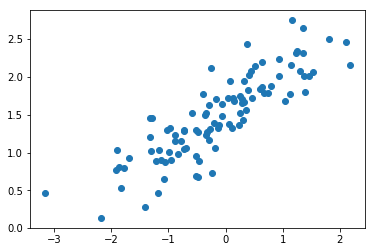

In [3]:
plt.plot(X, y, 'o');

# Loglikelihood function via potential

In [4]:
with pm.Model() as m0:
    beta = pm.Normal('beta', 0., 10.)
    a = pm.Normal('a', 0., 10.)
    pm.Normal('y', X*beta+a, 1., observed=y)
    
with pm.Model() as m1:
    beta = pm.Flat('beta')
    a = pm.Flat('a')
    
    pm.Potential('logp_beta', 
                 pm.Normal.dist(0., 10).logp(beta))
    pm.Potential('logp_a', 
                 pm.Normal.dist(0., 10).logp(a))
    pm.Potential('logp_obs', 
                 pm.Normal.dist(X*beta+a, 1.).logp(y))

In [5]:
m0.free_RVs

[beta, a]

In [7]:
m0.potentials

[]

In [6]:
m1.free_RVs

[beta, a]

In [8]:
m1.potentials

[logp_beta, logp_a, logp_obs]

In [9]:
m0.test_point

{'a': array(0.), 'beta': array(0.)}

In [10]:
m1.test_point

{'a': array(0.), 'beta': array(0.)}

In [11]:
m0.logp(m0.test_point)

array(-223.23743702)

In [12]:
m1.logp(m0.test_point)

array(-223.23743702)

In [13]:
assert m0.logp(m0.test_point) == m1.logp(m0.test_point)

In [14]:
logp_dlogp0 = m0.logp_dlogp_function(m0.free_RVs)

In [15]:
logp_dlogp0

In [16]:
logp_dlogp0.dict_to_array(dict(a=np.array(1.), beta=np.array(2.)))

array([2., 1.])

In [17]:
logp_dlogp0.set_extra_values({})
logp_dlogp0(np.asarray([2., 1.]))

(array(-250.94150728), array([-167.11059469,   74.48371803]))

In [18]:
logp_dlogp0(np.asarray([0., 0.]))

(array(-223.23743702), array([ 28.05366648, 148.22199786]))

In [19]:
logp_dlogp1 = m1.logp_dlogp_function(m1.free_RVs)

logp_dlogp1.set_extra_values({})
logp_dlogp1(np.asarray([2., 1.]))

(array(-250.94150728), array([-167.11059469,   74.48371803]))

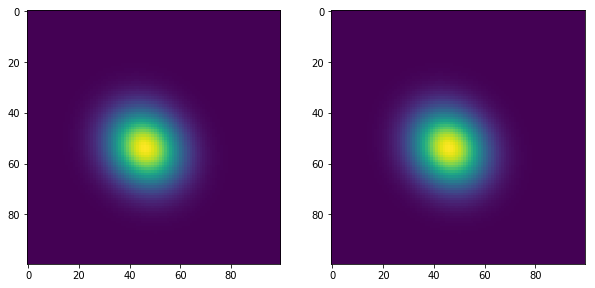

In [20]:
bv = np.linspace(0., 1., 100)
av = np.linspace(1., 2., 100)
bv_, av_ = np.meshgrid(bv, av)
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, logp_dlogp in enumerate([logp_dlogp0, logp_dlogp1]):
    logvec = np.asarray([logp_dlogp(np.asarray([b, a]))[0] 
              for b, a in zip(bv_.flatten(), av_.flatten())])
    ll = logvec.reshape(av_.shape)
    ax[i].imshow(np.exp(ll), cmap='viridis');

# Different parameterization that produce the same logp

In [13]:
with pm.Model() as m0:
    beta = pm.Normal('beta', 0, 10)
    a = pm.Normal('a', 0, 10)
    sd = pm.HalfNormal('sd', 5)
    pm.Normal('y', X*beta+a, sd, observed=y)
    trace0 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, a, beta]
100%|██████████| 1000/1000 [00:02<00:00, 482.88it/s]


In [14]:
with pm.Model() as m1:
    beta = pm.Normal('beta', 0, 10)
    a = pm.Normal('a', 0, 10)
    sd = pm.HalfNormal('sd', 5)
    pm.Normal('eps', 0, sd, observed=y - X*beta - a)
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, a, beta]
100%|██████████| 1000/1000 [00:01<00:00, 719.04it/s]


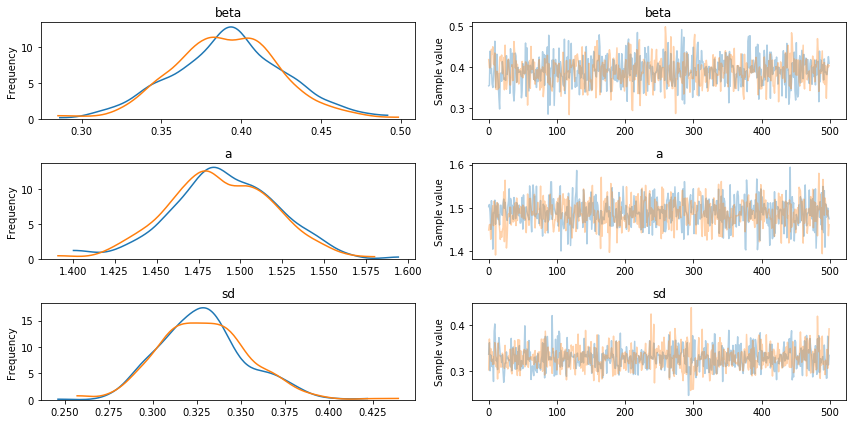

In [15]:
pm.traceplot(trace0);

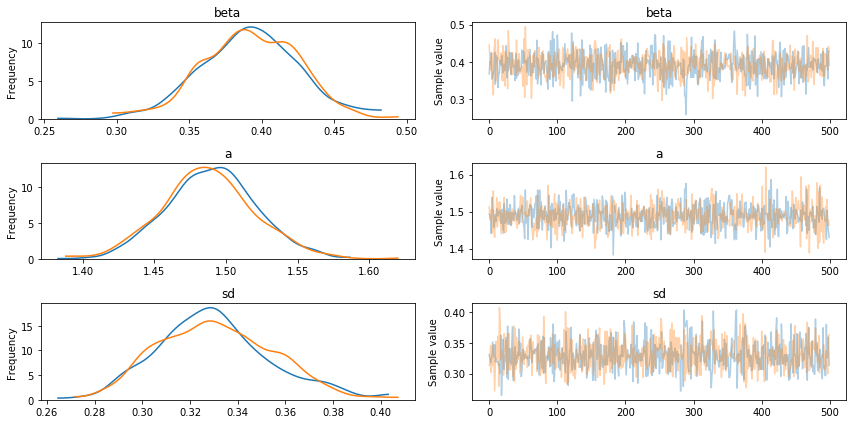

In [16]:
pm.traceplot(trace1);

In [17]:
m1.test_point

{'a': array(0.), 'beta': array(0.), 'sd_log__': array(1.38364656)}

In [18]:
m1.logp(m1.test_point)

array(-245.85390804)

In [19]:
m0.logp(m1.test_point)

array(-245.85390804)

In [20]:
with m0:
    map0 = pm.find_MAP()
map0

logp = -37.094, ||grad|| = 9.0595e-05: 100%|██████████| 22/22 [00:00<00:00, 1463.54it/s]


{'a': array(1.48973374),
 'beta': array(0.39252041),
 'sd': array(0.32273032),
 'sd_log__': array(-1.13093822)}

In [21]:
with m1:
    map1 = pm.find_MAP()
map1

logp = -37.094, ||grad|| = 9.0595e-05: 100%|██████████| 22/22 [00:00<00:00, 2954.59it/s]


{'a': array(1.48973374),
 'beta': array(0.39252041),
 'sd': array(0.32273032),
 'sd_log__': array(-1.13093822)}

In [23]:
with pm.Model() as m0:
    beta = pm.Normal('beta', 0, 10)
    a = pm.Normal('a', 0, 10)
    sd = pm.HalfNormal('sd', 5)
    pm.Normal('y', X*beta+a, sd, observed=y)

logp_dlogp = m0.logp_dlogp_function([beta, a])

In [24]:
logp_dlogp.set_extra_values({'sd_log__': np.log(1.)})

In [25]:
logp_dlogp.dict_to_array(dict(a=np.array(1.), beta=np.array(2.)))

array([2., 1.])

In [26]:
logp_dlogp(np.asarray([2., 1.]))

(array(-239.48382519), array([-159.61228445,   23.62736683]))

In [27]:
bv = np.linspace(0., 1., 100)
av = np.linspace(1., 2., 100)
bv_, av_ = np.meshgrid(bv, av)
logvec = np.asarray([logp_dlogp(np.asarray([b, a]))[0] 
          for b, a in zip(bv_.flatten(), av_.flatten())])

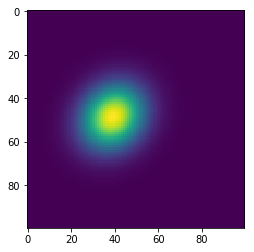

In [28]:
ll = logvec.reshape(av_.shape)
plt.imshow(np.exp(ll), cmap='viridis');

In [37]:
with pm.Model() as m0_:
    beta = pm.Normal('beta', 0, 1)
    a = pm.Normal('a', 0, 1)
    sd = pm.HalfNormal('sd', 5)
    pm.Normal('y', X*beta+a, sd, observed=y)

logp_dlogp = m0_.logp_dlogp_function([beta, a])

logp_dlogp.set_extra_values({'sd_log__': np.log(1.)})

logp_dlogp.dict_to_array(dict(a=np.array(1.), beta=np.array(2.)))

array([2., 1.])

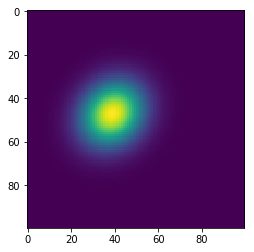

In [38]:
logvec = np.asarray([logp_dlogp(np.asarray([b, a]))[0] 
          for b, a in zip(bv_.flatten(), av_.flatten())])

ll = logvec.reshape(av_.shape)
plt.imshow(np.exp(ll), cmap='viridis');